# CV loop


In [25]:
%matplotlib inline
import numpy as np
import sys
import os
import time

caffe_root = '../../../caffe/'
sys.path.insert(0, caffe_root + 'python')
import caffe
from caffe import layers as L, params as P

import h5py

import matplotlib.pyplot as plt
# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
np_loaded_data_file = '../data/train_data_cleaned.npz'
if not os.path.isfile(np_loaded_data_file):
    print "%s does not exist. See facial_recog_kaggle.ipynb" % np_loaded_data_file
else:
    print "loading %s" % np_loaded_data_file
    npzfile = np.load(np_loaded_data_file)
    print "loaded: ", npzfile.files
    X_train_clean_cv, y_train_clean_cv = npzfile['X_train_clean_cv'], npzfile['y_train_clean_cv']
    X_val_clean_cv, y_val_clean_cv = npzfile['X_val_clean_cv'], npzfile['y_val_clean_cv']
    feature_labels = npzfile['feature_labels']
    print X_train_clean_cv.shape, y_train_clean_cv.shape
    print X_val_clean_cv.shape, y_val_clean_cv.shape


f = h5py.File('../data/train_data_lenet.hd5', 'w')
f.create_dataset('data', data=X_train_clean_cv, compression='gzip', compression_opts=4)
f.create_dataset('label', data=y_train_clean_cv, compression='gzip', compression_opts=4)
f.close()

f = h5py.File('../data/test_data_lenet.hd5', 'w')
f.create_dataset('data', data=X_val_clean_cv, compression='gzip', compression_opts=4)
f.create_dataset('label', data=y_val_clean_cv, compression='gzip', compression_opts=4)
f.close()

loading ../data/train_data_cleaned.npz
loaded:  ['X_val_clean_cv', 'y_val_clean_cv', 'y_train_clean_cv', 'feature_labels', 'X_train_clean_cv']
(1628, 1, 96, 96) (1628, 30)
(512, 1, 96, 96) (512, 30)


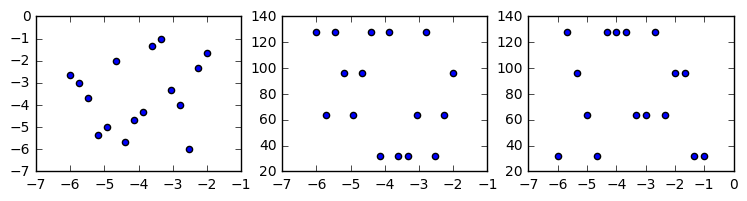

In [31]:
num_epochs = 100
td_size = X_train_clean_cv.shape[0]
# td_size = 50
val_data_size = X_val_clean_cv.shape[0]
num_labels = y_train_clean_cv.shape[1]

num_cv_points = 16

batch_size_vec = np.random.choice([32, 64, 96, 128], num_cv_points, replace=True)

#base_learning_rate_exps = np.random.uniform(-2, -6, num_cv_points)
base_learning_rate_exps = np.linspace(-2, -6, num_cv_points)
np.random.shuffle(base_learning_rate_exps)
base_learning_rate = np.power(10, base_learning_rate_exps)

#reg_param_exps = np.random.uniform(-1, -6, num_cv_points)
reg_param_exps = np.linspace(-1, -6, num_cv_points)
np.random.shuffle(reg_param_exps)
reg_param_vec = np.power(10, reg_param_exps)

plt.rcParams['figure.figsize'] = (9.0, 2.0)
plt.subplot(1, 3, 1)
plt.scatter(np.log10(base_learning_rate), np.log10(reg_param_vec))
plt.subplot(1, 3, 2)
plt.scatter(np.log10(base_learning_rate), (batch_size_vec))
plt.subplot(1, 3, 3)
plt.scatter(np.log10(reg_param_vec), (batch_size_vec))
plt.show()

In [35]:
%%time
from net_archs import lenet
from def_solver import create_solver

train_net_path = 'train_net.prototxt'
test_net_path = 'test_net.prototxt'
solver_config_fname_base = 'lenet_solver'

results = {}
for batch_size, base_lr, reg_param in zip(batch_size_vec, base_learning_rate, reg_param_vec):
    
    
    train_suffix = "__b_lr_%.02e__reg_param_%0.02e__batch_size_%d" % (base_lr, reg_param, batch_size)
    print "train_suffix = %s" % train_suffix
    
    with open(train_net_path, 'w') as f:
        f.write(str(lenet(hdf5_list='../data/train_hdf5.list', batch_size=batch_size)))

    with open(test_net_path, 'w') as f:
        f.write(str(lenet(hdf5_list='../data/test_hdf5.list', batch_size=batch_size)))
    
    s = create_solver(base_lr, reg_param, train_net_path, test_net_path)
    solver_config_fname = solver_config_fname_base + train_suffix + ".prototxt"
    with open(solver_config_fname, 'w') as f:
        f.write(str(s))
    
    solver = None
    solver = caffe.get_solver(solver_config_fname)
    
    num_iter_per_epoch = int(np.ceil(float(td_size) / batch_size))
    niter = num_iter_per_epoch * num_epochs

    niter_val = int(np.ceil( float(val_data_size) / batch_size))
    val_interval = num_iter_per_epoch

    print "batch_size = %d, base_learning_rate = %.02e, reg_param = %.02e" % (batch_size, base_lr, reg_param)
    
    print "niter = %d, val_interval = %d" % (niter, val_interval)

    train_error = np.zeros(niter)
    val_error = np.zeros( int(np.ceil(float(niter) / val_interval)))

    start_time = time.time()
    # iterations begin
    for it in range(niter):
        
        solver.step(1)

        train_error[it] = solver.net.blobs['loss'].data

        if (it % val_interval) == 0 or (it == niter-1):

            val_error_this = 0
            for test_it in range(niter_val):
                solver.test_nets[0].forward()
                val_error_this += solver.test_nets[0].blobs['loss'].data / niter_val

            val_error[it // val_interval] = val_error_this

            print "it = %d, train_error = %.02e, val_error = %0.02e" % (it, train_error[it], val_error[it // val_interval])
            
        results[(batch_size, base_lr, reg_param)] = (train_error, val_error)
    # iterations end
    
    
    # save model
    model_save_name = "lenet" + train_suffix + ".caffemodel"
    solver.net.save(model_save_name)
        
    end_time = time.time()
    print "elapsed time = %f" % (end_time - start_time)   
        
    

train_suffix = __b_lr_1.85e-06__reg_param_1.00e-03__batch_size_64
batch_size = 64, base_learning_rate = 1.847850e-06, reg_param = 1.000000e-03
niter = 2600, val_interval = 26
it = 0, train_error = 4.734111e+04, val_error = 4.551881e+04
it = 26, train_error = 1.184966e+04, val_error = 1.123915e+04
it = 52, train_error = 4.660687e+03, val_error = 4.216489e+03
it = 78, train_error = 3.413305e+03, val_error = 3.345082e+03
it = 104, train_error = 3.049890e+03, val_error = 2.942544e+03
it = 130, train_error = 2.637200e+03, val_error = 2.695997e+03
it = 156, train_error = 2.359218e+03, val_error = 2.511645e+03
it = 182, train_error = 2.211045e+03, val_error = 2.362602e+03
it = 208, train_error = 2.316659e+03, val_error = 2.236344e+03
it = 234, train_error = 2.318023e+03, val_error = 2.127590e+03
it = 260, train_error = 2.060597e+03, val_error = 2.032707e+03
it = 286, train_error = 1.561454e+03, val_error = 1.949443e+03
it = 312, train_error = 1.484650e+03, val_error = 1.876284e+03
it = 338, t

KeyboardInterrupt: 

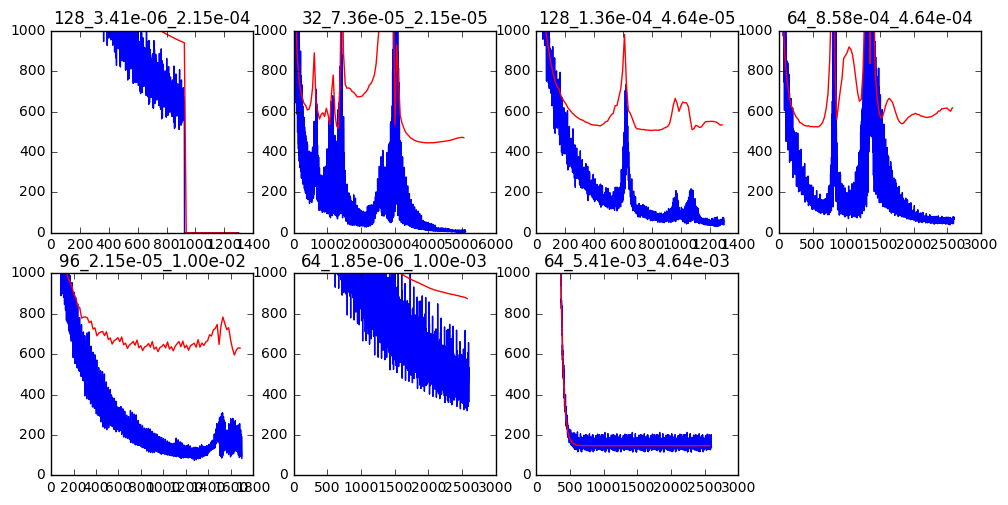

In [38]:
plt.rcParams['figure.figsize'] = (12.0, 12.0)
N_img_x = int(np.floor(np.sqrt(num_cv_points)))
N_img_y = int(np.ceil(np.sqrt(num_cv_points)))
cnt = 1
for key in results:
    batch_size, _, _ = key
    train_error, val_error = results[key]
    
    num_iter_per_epoch = int(np.ceil(float(td_size) / batch_size))
    val_interval = num_iter_per_epoch
    
    plt.subplot(N_img_x, N_img_y, cnt)
    plt.plot(np.arange(len(train_error)), train_error, 'b', label='train_error')
    plt.plot(val_interval * np.arange(len(val_error)), val_error, 'r', label='val_error')
    plt.ylim([0,1000])
    plt.title("%d_%0.02e_%0.02e" % key)
    
    cnt += 1
plt.show()

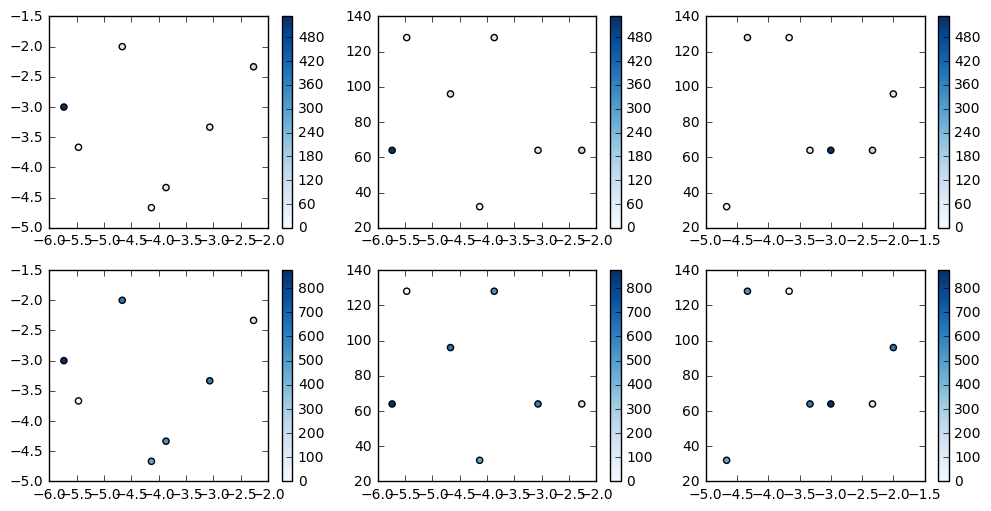

In [37]:
import matplotlib.cm as cm
plt.rcParams['figure.figsize'] = (12.0, 6.0)
t_error = []
v_error = []
b_lr_vec = []
b_size_vec = []
r_param_vec = []

for key in results:
    batch_size, b_lr, reg_param = key
    train_error, val_error = results[key]
    
    b_lr_vec.append(b_lr)
    b_size_vec.append(batch_size)
    r_param_vec.append(reg_param)
    
    t_error.append(train_error[-1])
    v_error.append(val_error[-1])
    
        
plt.subplot(2, 3, 1)
plt.scatter(np.log10(b_lr_vec), np.log10(r_param_vec), c=t_error, cmap=cm.Blues)
plt.colorbar()
#     plt.xlim([1e-3, 1e-6])

plt.subplot(2, 3, 4)
plt.scatter(np.log10(b_lr_vec), np.log10(r_param_vec), c=v_error, cmap=cm.Blues)
plt.colorbar()
#     plt.xlim([1e-3, 1e-6])

plt.subplot(2, 3, 2)
plt.scatter(np.log10(b_lr_vec), (b_size_vec), c=t_error, cmap=cm.Blues)
plt.colorbar()
#     plt.xlim([1e-3, 1e-6])

plt.subplot(2, 3, 5)
plt.scatter(np.log10(b_lr_vec), (b_size_vec), c=v_error, cmap=cm.Blues)
plt.colorbar()

plt.subplot(2, 3, 3)
plt.scatter(np.log10(r_param_vec), (b_size_vec), c=t_error, cmap=cm.Blues)
plt.colorbar()
#     plt.xlim([1e-3, 1e-6])

plt.subplot(2, 3, 6)
plt.scatter(np.log10(r_param_vec), (b_size_vec), c=v_error, cmap=cm.Blues)
plt.colorbar()

plt.show()